# Implementation

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scikitplot as skplt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from tqdm import tqdm_notebook

from sklearn.metrics import classification_report, recall_score, precision_score ,average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.impute import SimpleImputer
from yellowbrick.classifier import PrecisionRecallCurve, ConfusionMatrix
from sklearn.model_selection import train_test_split, cross_validate ,KFold, StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 
import shap
shap.initjs() 

%matplotlib inline 
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
# import data
path = 'C:/Users/GN/Machine Learning/creditcard.csv' 
credit = pd.read_csv(path)
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print('Rows: {} | Columns: {} '.format(credit.shape[0], credit.shape[1]))

Rows: 284807 | Columns: 31 


In [4]:
# Descritive stats 
credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Normal: 284315 |  Fraud: 492


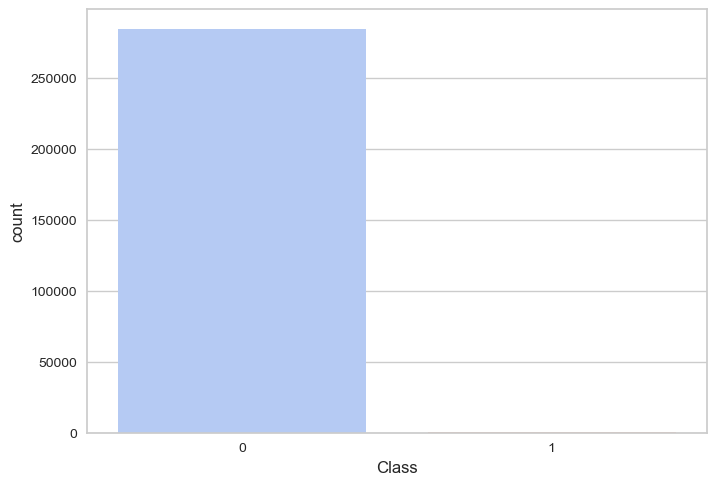

In [5]:
# class
sns.countplot(x=credit['Class'], palette='coolwarm')
print('Normal: {} |  Fraud: {}'.format(credit[credit['Class']==0].shape[0] , credit[credit['Class']==1].shape[0]))

# Data Cleaning

Before starting an analysis of the data, we will clean the data, it will not be necessary to delete duplicate transactions as it makes total sense, to contain transactions that are done routinely.

Missing values, Noises, Data type

In [6]:
def missing_values(data):

    """ Summary of null data
        contained in the dataset """

    # total nulls     
    missing = data.isnull().sum()
    total = missing.sort_values(ascending=True)
    
    # percentage  
    percent = (missing / len(data.index ) * 100).round(2).sort_values(ascending=True)

    # concatenation 
    table_missing = pd.concat([total, percent], axis=1, keys=['NA numbers', 'NA percentage'])

    return table_missing

In [7]:
missing_values(credit)

,NA numbers,NA percentage
Time,0,0.0
V28,0,0.0
V27,0,0.0
V26,0,0.0
V25,0,0.0
V24,0,0.0
V23,0,0.0
V22,0,0.0
V21,0,0.0
V20,0,0.0


In [8]:
# data types
credit.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

# Data analysis

We will identify the period of time, in which a fraudulent transaction is made, compared to normal transactions



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751





`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: title={'center': 'Seconds Fraudulent Transaction'}, xlabel='Time', ylabel='Density'>

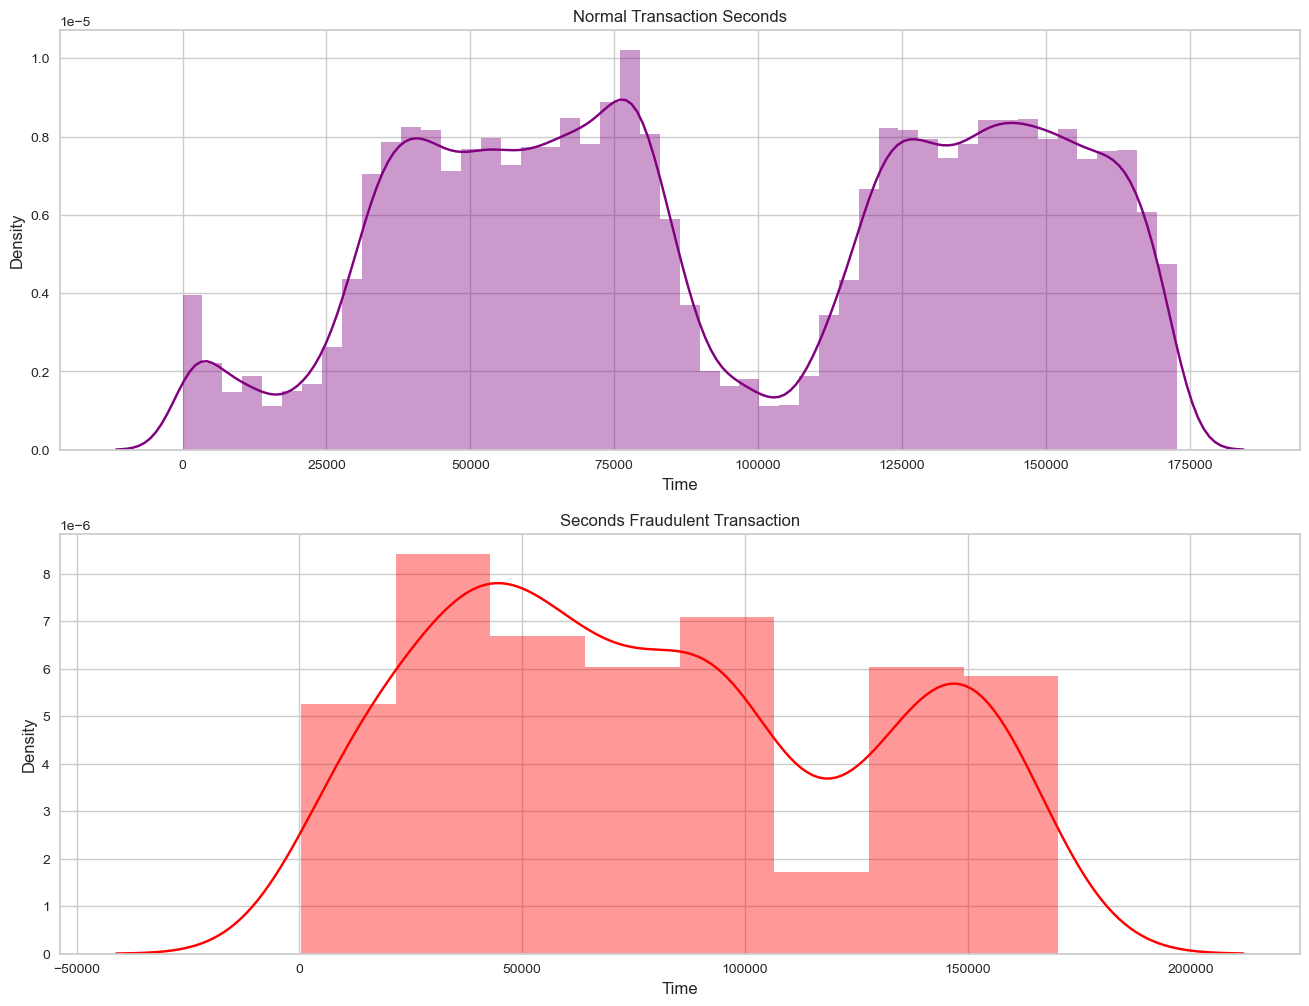

In [11]:
# Compare Distributions

plt.figure(figsize=(16,12))

plt.subplot(2,1,1)
plt.title('Normal Transaction Seconds')
sns.distplot(credit[credit['Class']==0]['Time'], color='purple')

print('\n')
print('\n')

plt.subplot(2,1,2)
plt.title('Seconds Fraudulent Transaction')
sns.distplot(credit[credit['Class']==1]['Time'], color='red')

In [12]:
# Repeated fraud?

fraud = credit[credit['Class']==1].loc[credit.duplicated()]
print('Repeated scams: {} '.format(len(fraud)))
print('\n')
fraud

Repeated scams: 19 




,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
102442,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
102443,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
102444,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
102445,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
102446,68207.0,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,1.00,1
141258,84204.0,-0.937843,3.462889,-6.445104,4.932199,-2.233983,-2.291561,-5.695594,1.338825,-4.322377,...,1.066550,-0.521657,-0.319917,-0.405859,0.906802,1.165784,1.374495,0.729889,0.00,1
141260,84204.0,-1.927453,1.827621,-7.019495,5.348303,-2.739188,-2.107219,-5.015848,1.205868,-4.382713,...,1.376938,-0.792017,-0.771414,-0.379574,0.718717,1.111151,1.277707,0.819081,512.25,1
143334,85285.0,-7.030308,3.421991,-9.525072,5.270891,-4.024630,-2.865682,-6.989195,3.791551,-4.622730,...,1.103398,-0.541855,0.036943,-0.355519,0.353634,1.042458,1.359516,-0.272188,0.00,1
143336,85285.0,-6.713407,3.921104,-9.746678,5.148263,-5.151563,-2.099389,-5.937767,3.578780,-4.684952,...,0.954272,-0.451086,0.127214,-0.339450,0.394096,1.075295,1.649906,-0.394905,252.92,1
150661,93853.0,-6.185857,7.102985,-13.030455,8.010823,-7.885237,-3.974550,-12.229608,4.971232,-4.248307,...,2.502772,0.481691,0.480958,0.360319,-0.293354,-0.199193,-0.203917,0.398927,44.90,1


There were 19 repeated frauds in this two days, there are cases where there were three frauds with the same value, the rest is just two, something that stands out is the low values of the transactions that there was a greater number of fraud, perhaps because the fraudster considers himself the risk of being caught compared to the number of attempts.

In [13]:
# cmap
cmap = sns.diverging_palette(120, 40, sep=20, as_cmap=True, center='dark')

<Axes: title={'center': 'Correlation matrix'}>

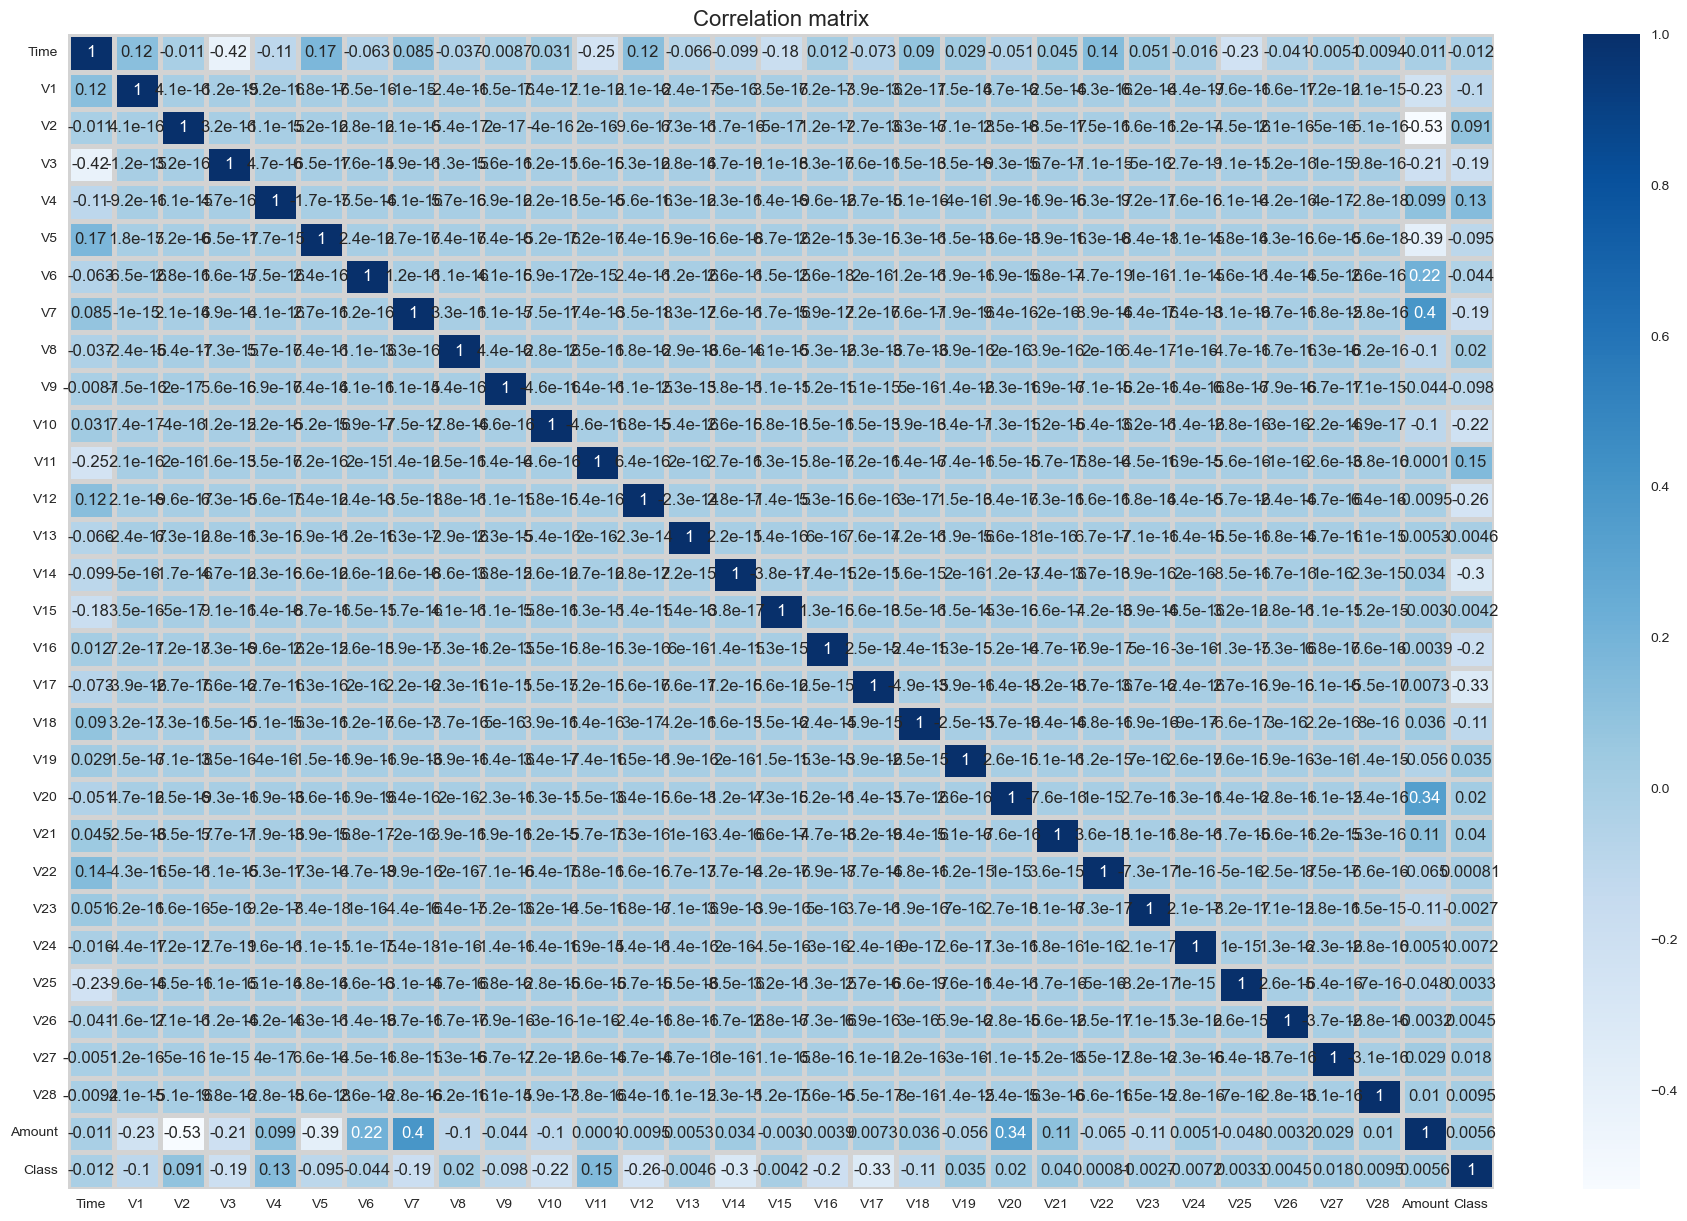

In [14]:
# Correlation
corr = credit.corr(method='pearson')

fig, ax = plt.subplots(figsize=(23,15))

# cmap=Greys

plt.title('Correlation matrix', fontsize=16)
print('\n')
correlacao = sns.heatmap(corr, annot=True, cmap='Blues', ax=ax, lw=3.3, linecolor='lightgray')
correlacao

Looking at Pearson's correlations, we can see that there are no big positive correlations, only a few features go above 0.30 correlation, which are V7 with Amount | V20 with Amount 

# Distributions

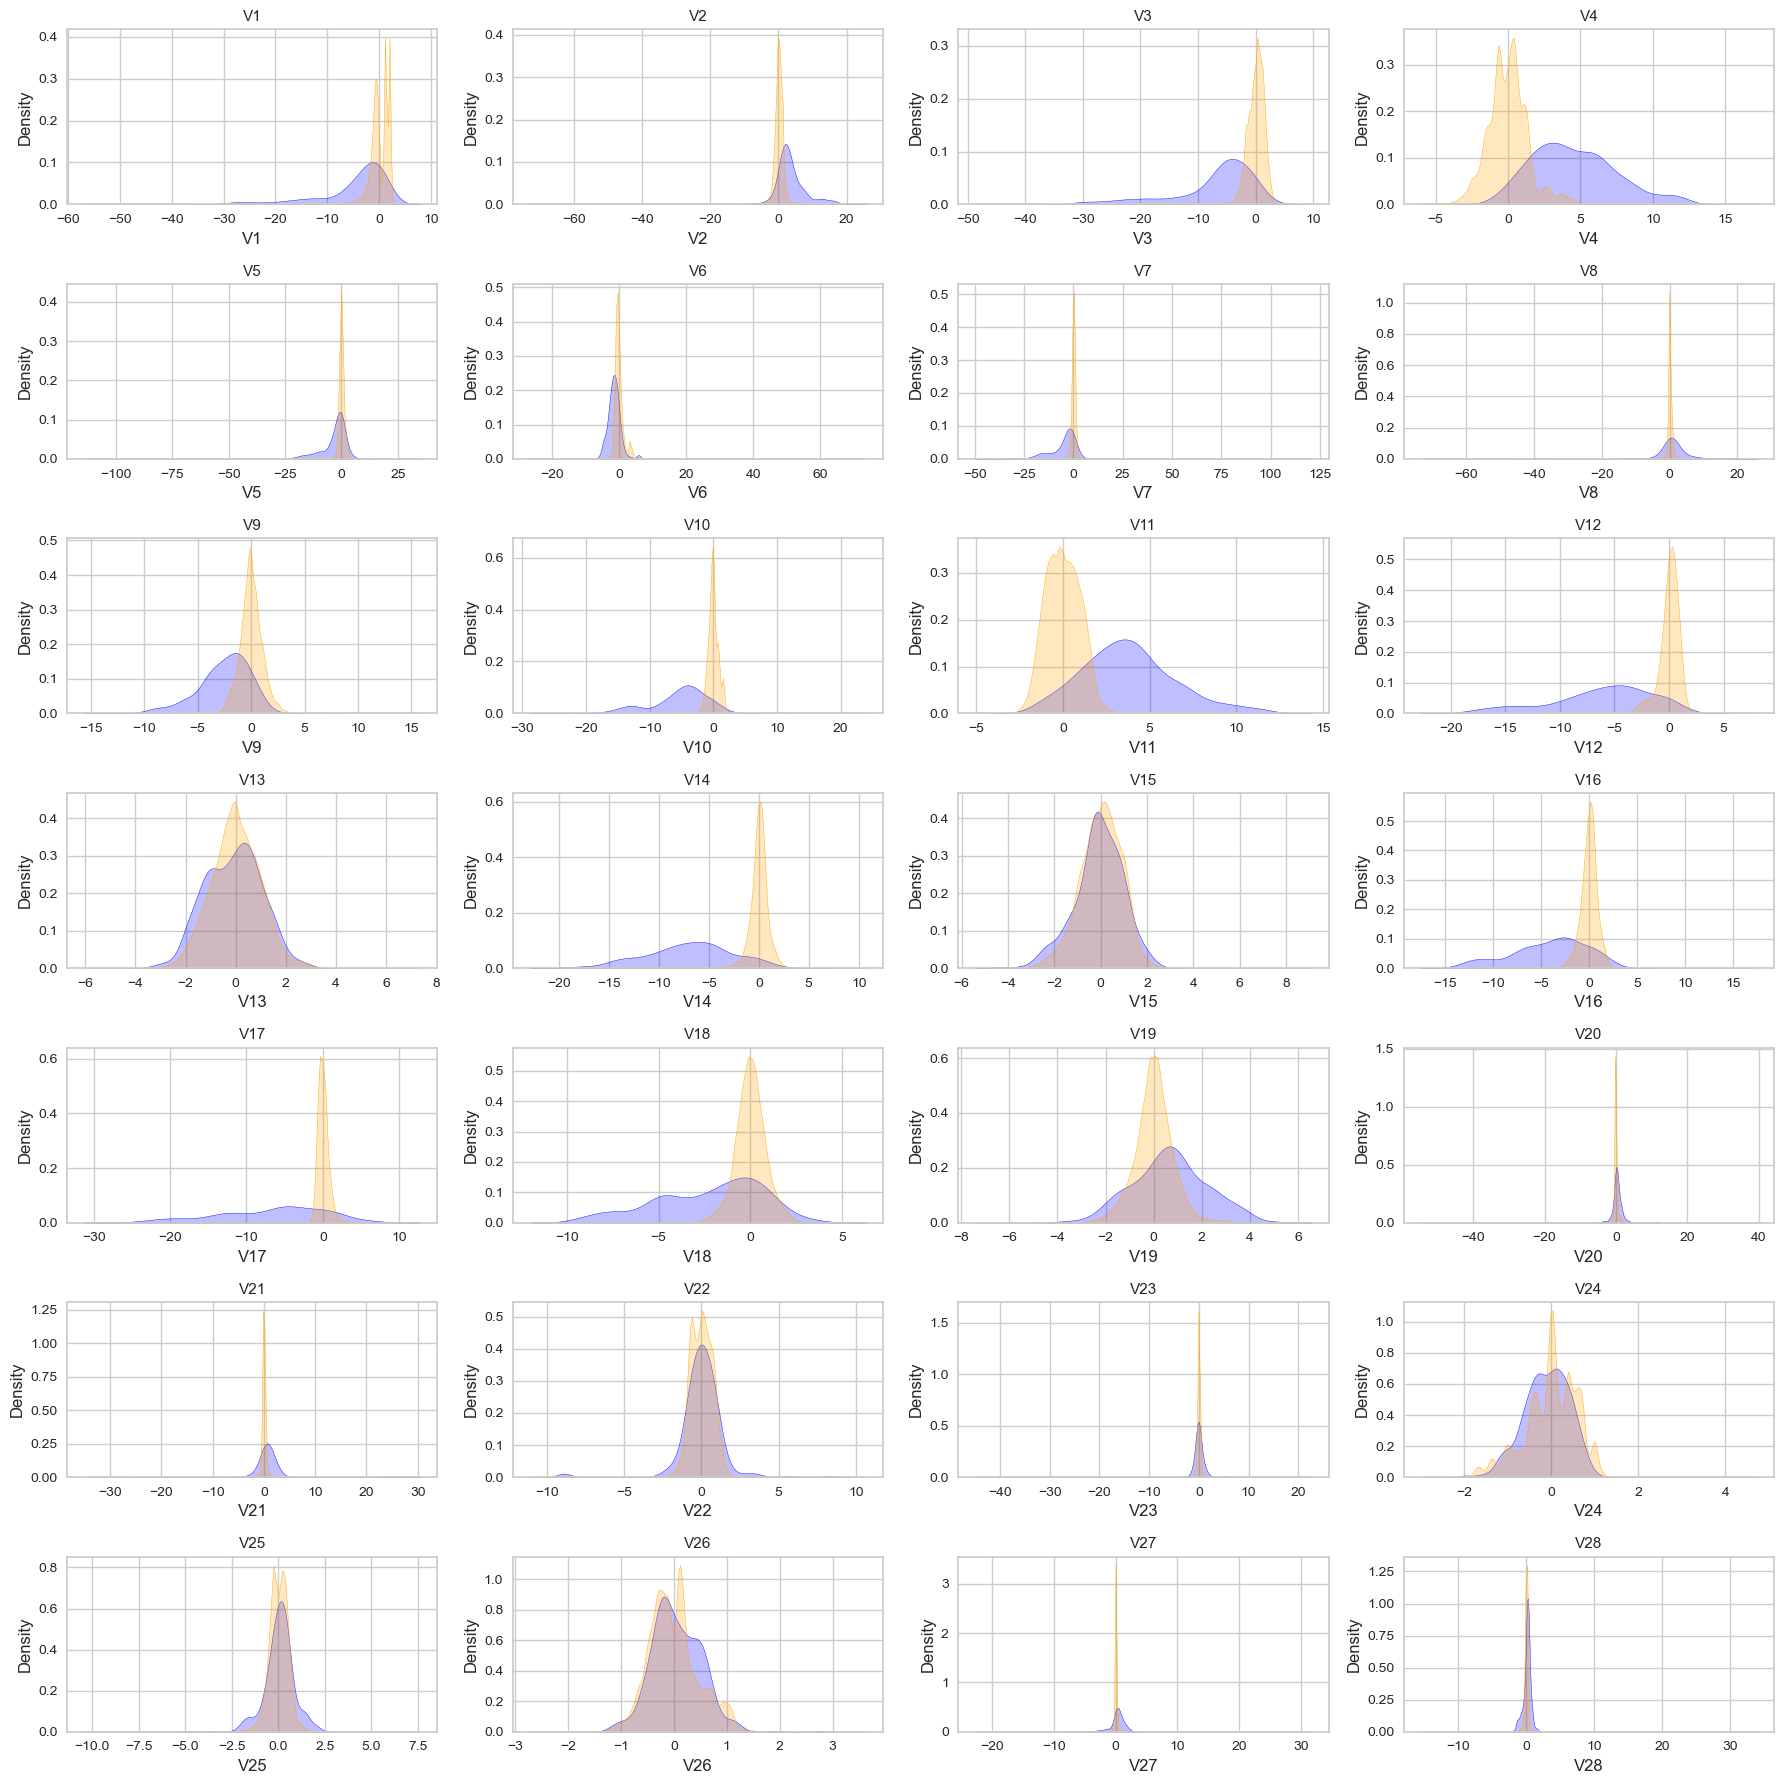

In [15]:
# cols plot  
cols_names = credit.drop(['Class', 'Amount', 'Time'], axis=1)
idx = 0

# Spliting classes
fraud = credit[credit['Class']==1]
normal = credit[credit['Class']==0]

# figure plot  
fig, ax = plt.subplots(nrows=7, ncols=4, figsize=(18,18))
fig.subplots_adjust(hspace=1, wspace=1)

for col in cols_names:
    idx += 1
    plt.subplot(7, 4, idx)
    sns.kdeplot(fraud[col], label="Normal", color='blue', shade=True)
    sns.kdeplot(normal[col], label="Fraud", color='orange', shade=True)
    plt.title(col, fontsize=11)
    plt.tight_layout()

In [16]:
# Range of fraud values 
credit[credit['Class']==1]['Amount'].value_counts

<bound method IndexOpsMixin.value_counts of 541         0.00
623       529.00
4920      239.93
6108       59.00
6329        1.00
           ...  
279863    390.00
280143      0.76
280149     77.89
281144    245.00
281674     42.53
Name: Amount, Length: 492, dtype: float64>

In [17]:
# What is the average value of the fraudulent transaction?
print('Average Fraud: {} | Average Normal: {}'.format(credit[credit['Class']==1]['Amount'].mean() , credit[credit['Class']==0]['Amount'].mean()))

Average Fraud: 122.21132113821139 | Average Normal: 88.29102242231328


In [18]:
# What is the highest fraud value?
print('Higher fraud value: {}  | Higher normal value: {}'.format(credit[credit['Class']==1]['Amount'].max(), credit[credit['Class']==0]['Amount'].max()))

Higher fraud value: 2125.87  | Higher normal value: 25691.16


<Axes: title={'center': 'Value of Transactions by Class (Normal | Fraud)'}, xlabel='Class', ylabel='Amount'>

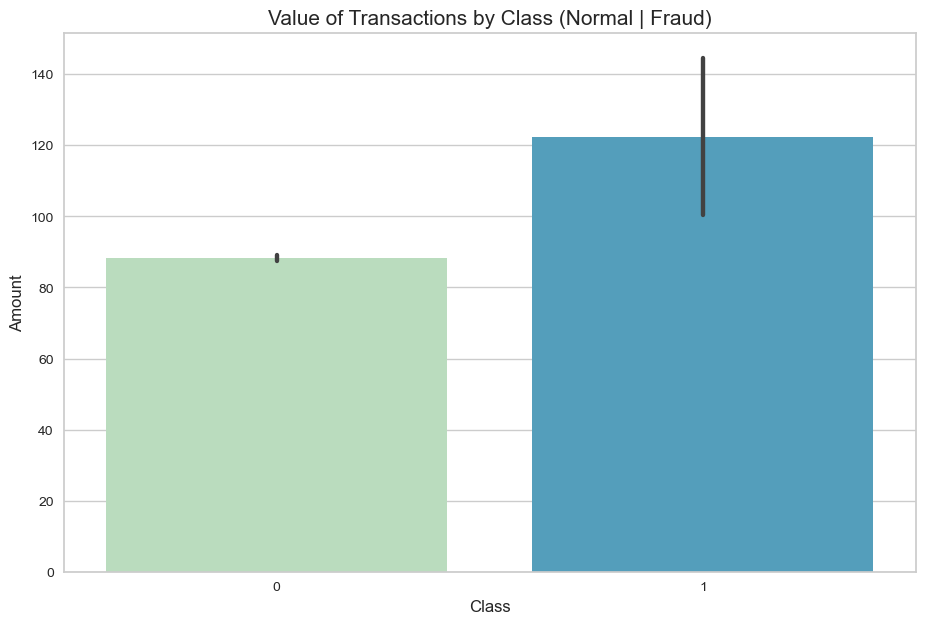

In [19]:
# Transaction Amount

plt.figure(figsize=(11,7))
plt.title('Value of Transactions by Class (Normal | Fraud)', fontsize=15)
sns.barplot(x='Class', y='Amount', data=credit, palette='GnBu')

<Axes: title={'center': 'Transactions'}, xlabel='Amount', ylabel='Density'>

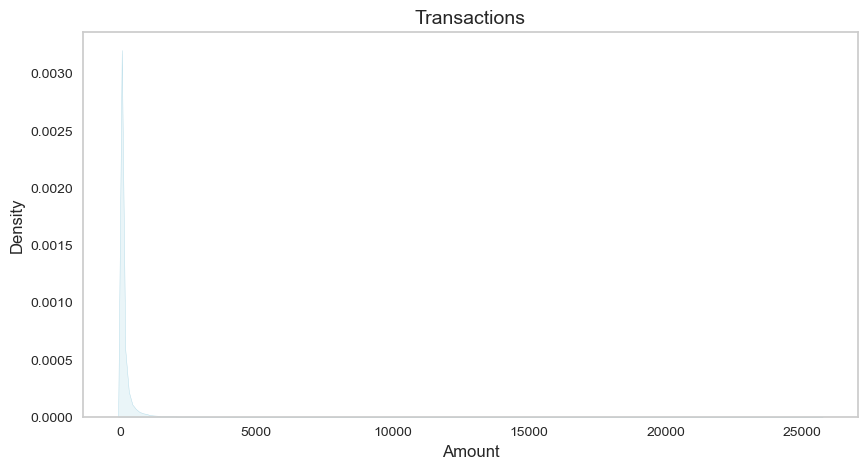

In [20]:
# Distribution of Transaction amounts
plt.figure(figsize=(10,5))
plt.title('Transactions', fontsize=14)
plt.grid(False)
sns.kdeplot(credit['Amount'], color='lightblue', shade=True)

# Baseline

In [21]:
# Separating feature | class

X = credit.drop('Class', axis=1)
y = credit['Class']

# Train|Test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


# StandardScaler 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Encoder 
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [22]:
# Baseline model

baseline = LogisticRegression(random_state=42)
baseline.fit(X_train, y_train)
y_baseline = baseline.predict(X_test)

# Probabilities 
y_proba_baseline = baseline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_baseline))
print('\n')
print('AUC: {}%'.format(roc_auc_score(y_test, y_proba_baseline)))
print('Precision-Recall: {}'.format(average_precision_score(y_test, y_proba_baseline)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.88      0.63      0.74       136

    accuracy                           1.00     85443
   macro avg       0.94      0.82      0.87     85443
weighted avg       1.00      1.00      1.00     85443



AUC: 0.9783093967187025%
Precision-Recall: 0.7883251929468739


Baseline

AUC: 0.97

AUPRC: 0.78

Precision: 0.88

Recall: 0.63


# XGboost + SMOTE

In [23]:
X = credit.drop('Class', axis=1)
y = credit['Class']


# Validation
KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
 
precision_xgboost = []
recall_xgboost = []
auc_xgboost = []
precision_recall_xgboost = []


fold = 0
for train_index, test_index in KFold.split(X,y):
      fold += 1 
      print('Fold: ', fold)
      print('Train: ',train_index.shape[0])
      print('Test: ', test_index[0])

      # OverSampling SMOTE 
      smt = SMOTE(random_state=42)
      X, y = smt.fit_resample(X, y)
      print('Normal: {}  |  Fraud: {}'.format(np.bincount(y)[0], np.bincount(y)[1]))

      # spliting data  
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y[train_index], y[test_index] 

      
      # pre-processing  
      scaler = QuantileTransformer()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)

      # XGboost 
      xgb = XGBClassifier(n_estimators=300, max_delta_step=1 , eval_metric='aucpr', cpu_history='cpu', random_state=42)
      xgb.fit(X_train, y_train)
      y_pred = xgb.predict(X_test)
  

      # metrics 
      precision_recall_xgboost = average_precision_score(y_test, y_pred)
      precision_xgboost = precision_score(y_test, y_pred)
      recall_xgboost = recall_score(y_test, y_pred)
      auc_xgboost  = roc_auc_score(y_test, y_pred)
      print('Precision-Recall: ', average_precision_score(y_test, y_pred))
      print('\n')
      print('\n')



# Final Validation 
print('Precision-Recall: ', np.mean(precision_recall_xgboost))
print('Recall: ', np.mean(recall_xgboost))
print('Precision: ', np.mean(precision_xgboost))
print('AUC: ', np.mean(auc_xgboost))

Fold:  1
Train:  227845
Test:  5
Normal: 284315  |  Fraud: 284315
[19:04:04] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "cpu_history" } are not used.

Precision-Recall:  0.7296967072501639




Fold:  2
Train:  227845
Test:  1
Normal: 284315  |  Fraud: 284315
[19:05:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "cpu_history" } are not used.

Precision-Recall:  0.8286839674168068




Fold:  3
Train:  227846
Test:  0
Normal: 284315  |  Fraud: 284315
[19:06:11] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "cpu_history" } are not used.

Precision-Recall:  0.807483775097441




Fold:  4
Train:  227846
Test:  14
Normal: 284315  |  Fraud: 284315
[19:07:

XGboost


AUC:  0.8978712530331584
Precision:  0.8863636363636364
Recall:  0.7959183673469388
Precision-Recall:  0.705824215761466






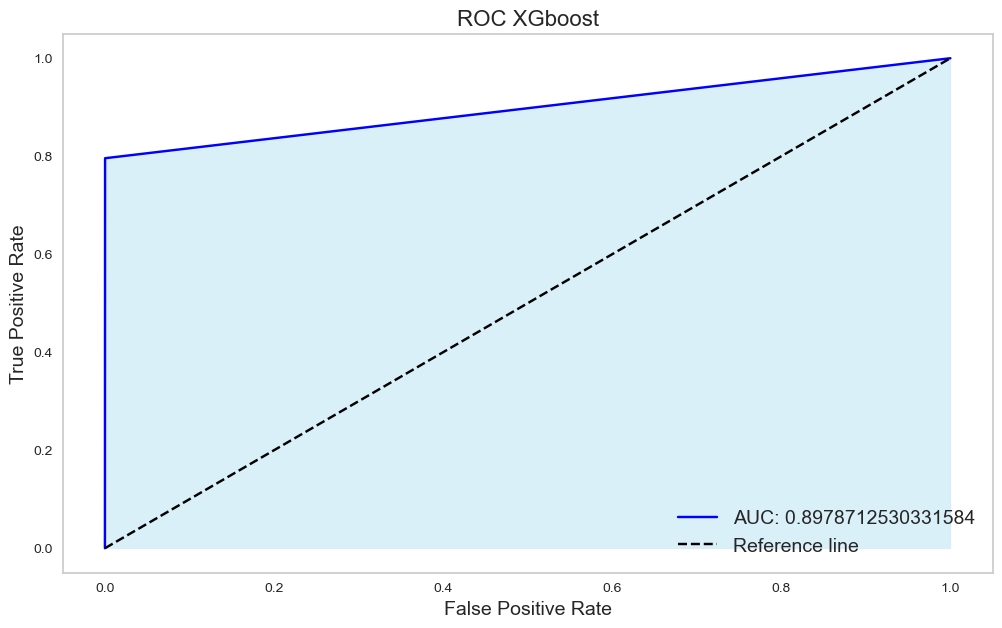

In [24]:
# Validation XGboost + SMOTE
print('XGboost')
print('\n')

print('AUC: ', np.mean(auc_xgboost))
print('Precision: ', np.mean(precision_xgboost))
print('Recall: ', np.mean(recall_xgboost))
print('Precision-Recall: ', np.mean(precision_recall_xgboost))


print('\n')
print('\n')

# Curva ROC random forest 
roc_auc_xgboost = np.mean(auc_xgboost)
fpr_xgboost, tpr_xgboost, thresholds_xgboost = roc_curve(y_test, y_pred)

# plot 
plt.figure(figsize=(12,7))
plt.plot(fpr_xgboost, tpr_xgboost, color='blue', label='AUC: {}'.format(roc_auc_xgboost))
plt.fill_between(fpr_xgboost, tpr_xgboost, color='skyblue', alpha=0.3)
plt.plot([0,1], [0,1], color='black', ls='--', label='Reference line')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC XGboost', fontsize=16)
plt.legend(loc=4, fontsize=14)
plt.grid(False)
plt.show()

0.8424241592225501

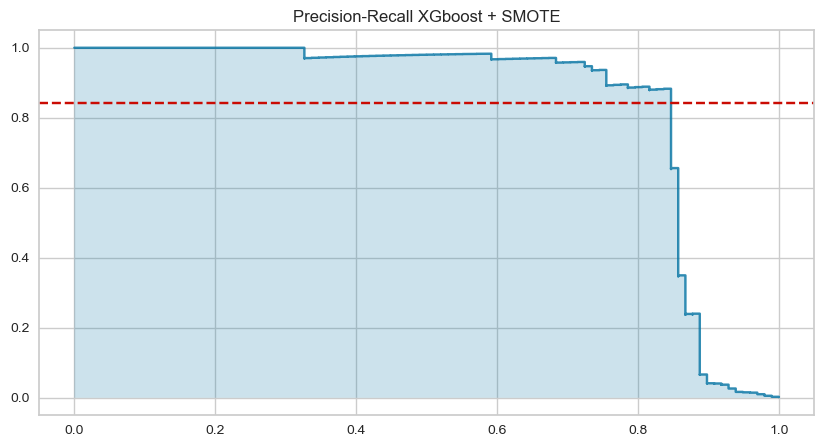

In [25]:
# Precision-Recall XGboost + SMOTE 

plt.figure(figsize=(10,5))
plt.title('Precision-Recall XGboost + SMOTE')
viz = PrecisionRecallCurve(xgb)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)

# XGboost + NearMiss

In [26]:
X = credit.drop('Class', axis=1)
y = credit['Class']

# UnderSampling NearMiss
under = NearMiss()
X,y = under.fit_resample(X, y)

# Validation
KFold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

resultados = []
fold = 0
for train_index, test_index in KFold.split(X,y):
      fold += 1 
      print('Fold: ', fold)
      print('Train: ',train_index.shape[0])
      print('Test: ', test_index[0])

      # Unbalanced class 
      print('Normal: {} | Fraud: {}'.format(np.bincount(y)[0], np.bincount(y)[1]))


      # spliting data 
      X_train, X_test = X.loc[train_index], X.loc[test_index]
      y_train, y_test = y[train_index], y[test_index] 

      
      # pre-processing 
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_test = scaler.transform(X_test)


      # Encoder 
      encoder = LabelEncoder()
      y_train = encoder.fit_transform(y_train)
      y_test = encoder.transform(y_test)


      # XGboost 
      xgb = XGBClassifier(n_estimators=300, max_delta_step=1 ,eval_metric='aucpr',cpu_history='cpu', random_state=42)
      xgb.fit(X_train, y_train)
      y_pred = xgb.predict(X_test)

    # Metrics
      precision_recall_xgboost = average_precision_score(y_test, y_pred)
      precision_xgboost = precision_score(y_test, y_pred)
      recall_xgboost = recall_score(y_test, y_pred)
      auc_xgboost  = roc_auc_score(y_test, y_pred)
      print('Precision-Recall: ', average_precision_score(y_test, y_pred))
      print('\n')
      print('\n')



# Final Validation   
print('Precision-Recall: ', np.mean(precision_recall_xgboost))
print('Recall: ', np.mean(recall_xgboost))
print('Precision: ', np.mean(precision_xgboost))
print('AUC: ', np.mean(auc_xgboost))

Fold:  1
Train:  787
Test:  0
Normal: 492 | Fraud: 492
[19:09:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "cpu_history" } are not used.

Precision-Recall:  0.9646288051041234




Fold:  2
Train:  787
Test:  5
Normal: 492 | Fraud: 492
[19:09:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "cpu_history" } are not used.

Precision-Recall:  0.9745183923823337




Fold:  3
Train:  787
Test:  2
Normal: 492 | Fraud: 492
[19:09:41] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "cpu_history" } are not used.

Precision-Recall:  0.9361207642570949




Fold:  4
Train:  787
Test:  9
Normal: 492 | Fraud: 492
[19:09:41] WARNING: C:/buildkite-agent/builds/build

XGboost


AUC:  0.933673469387755
Precision:  0.956989247311828
Recall:  0.9081632653061225
Precision-Recall:  0.9150208470484968






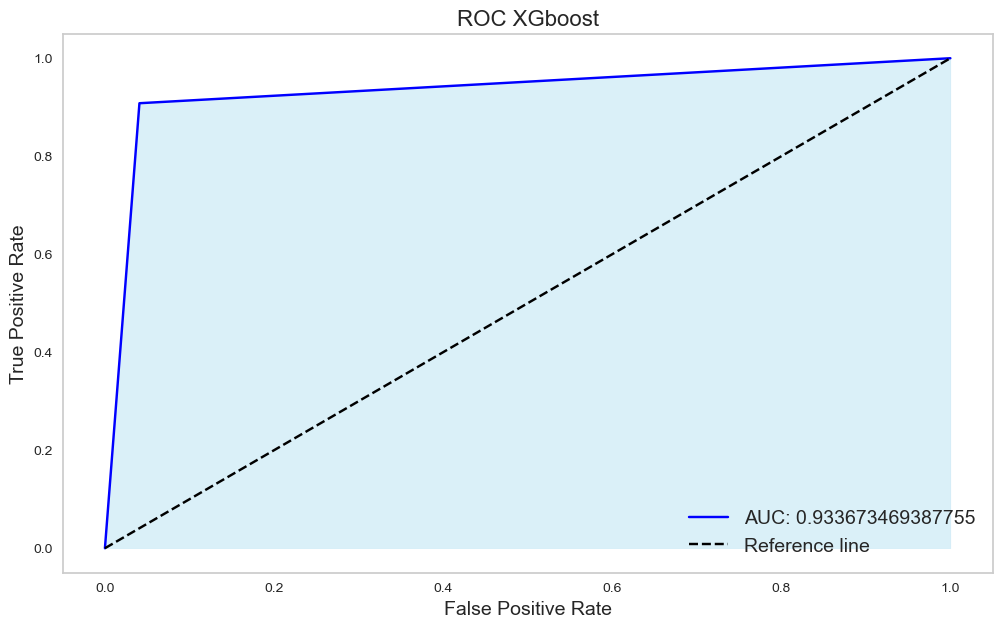

In [27]:
# Validation XGboost + NearMiss  
print('XGboost')
print('\n')

print('AUC: ', np.mean(auc_xgboost))
print('Precision: ', np.mean(precision_xgboost))
print('Recall: ', np.mean(recall_xgboost))
print('Precision-Recall: ', np.mean(precision_recall_xgboost))


print('\n')
print('\n')

# Curva ROC random forest 
roc_auc_xgboost = np.mean(auc_xgboost)
fpr_xgboost, tpr_xgboost, thresholds_xgboost = roc_curve(y_test, y_pred)

# plot 
plt.figure(figsize=(12,7))
plt.plot(fpr_xgboost, tpr_xgboost, color='blue', label='AUC: {}'.format(roc_auc_xgboost))
plt.fill_between(fpr_xgboost, tpr_xgboost, color='skyblue', alpha=0.3)
plt.plot([0,1], [0,1], color='black', ls='--', label='Reference line')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC XGboost', fontsize=16)
plt.legend(loc=4, fontsize=14)
plt.grid(False)
plt.show()

0.9834961133365601

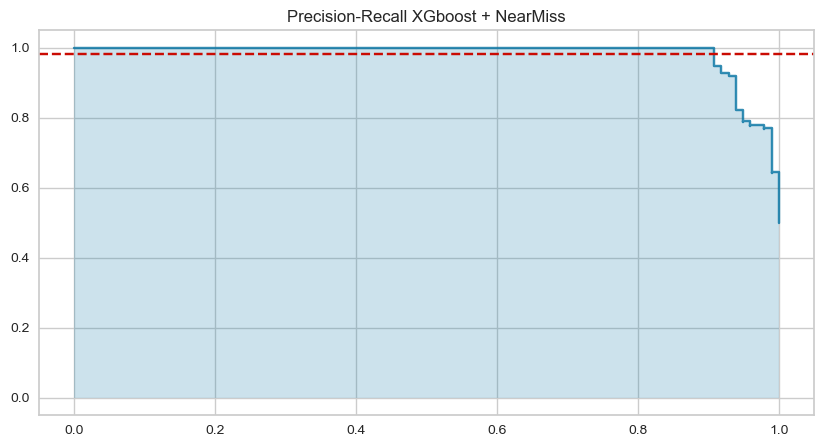

In [28]:
# Precision-Recall XGboost + NearMiss 

plt.figure(figsize=(10,5))
plt.title('Precision-Recall XGboost + NearMiss')
viz = PrecisionRecallCurve(xgb)
viz.fit(X_train, y_train)
viz.score(X_test, y_test)

# XGBoost Summary
The best combination so far was XGboost + UnderSampling (NearMiss) we were able to obtain very good values, we reduced our majority class, balancing the classes the algorithm managed to better generalize the data, with an AUPRC of 94% in the validation, it was an excellent result of the model, the synthetic data that SMOTE ends up not making much sense for the algorithm, as they are "repeated data" and that shows, very little generalization of Frauds

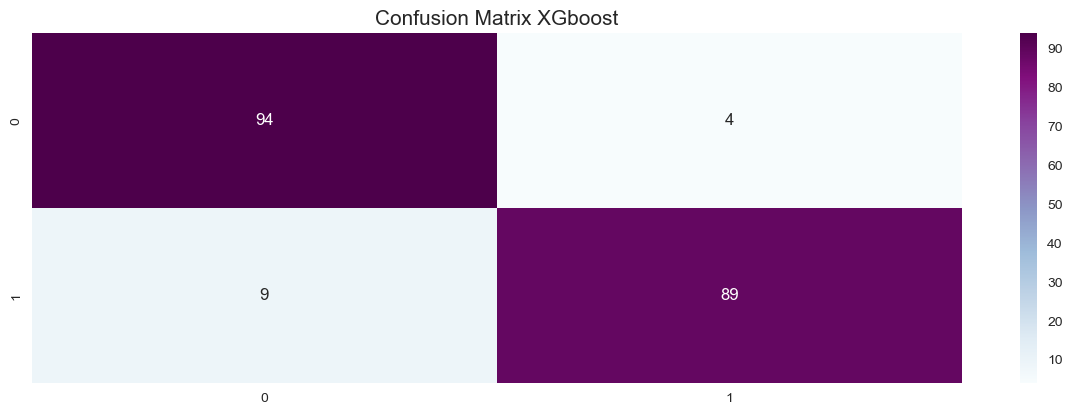

In [29]:
# Confusion Matrix  


plt.figure(figsize=(15,10))

plt.subplot(2, 1, 1)
plt.title('Confusion Matrix XGboost', fontsize=15)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='BuPu')

print('\n')
print('\n')